# Find the fingerprints of ENSO and the IPO in observed gridded datasets

Purpose
-------

    1.    Decompose the temperature time series into Intrinsic Mode Functions (IMFs) using EMD.
            i)  remove monthly climatology
            ii) remove linear trend over timeseries
    2.    Identify and correlate relevant IMFs with known indices for ENSO and IPO.
    3.    Compute slope of relationship between ENSO/IPO and variable of interest to quantify effect of ENSO/IPO


### IMPORTS

In [1]:

import sys
import os
import glob
import warnings
from joblib import Parallel, delayed

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import cmocean.cm as cmo
from cmocean.tools import lighten
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# oceanographic
import gsw as gsw

# statistics
import scipy as sci
from scipy.signal import hilbert
from PyEMD import EMD, CEEMDAN

# regridding package
import xesmf as xe

# ACCESS-NRI intake catalogue
import intake

# Copernicus marine toolbox
#import copernicusmarine
#from pprint import pprint
#copernicusmarine.login()

# print versions of packages
print("python version =",sys.version[:5])
print("numpy version =", np.__version__)
print("pandas version =", pd.__version__)
print("scipy version =", sci.__version__)
print("xarray version =", xr.__version__)
print("xesmf version =", xe.__version__)
print("cartopy version =", sys.modules[ccrs.__package__].__version__)
print("matplotlib version =", sys.modules[plt.__package__].__version__)
print("cmocean version =", sys.modules[cmo.__package__].__version__)


wrkdir="/g/data/es60/pjb581/SPC"
os.chdir(wrkdir)
os.getcwd()


/g/data/es60/pjb581/miniforge3/envs/pyEMD_env/lib/python3.10/site-packages/esmpy/interface/loadESMF.py:94: VersionWarning: ESMF installation version 8.8.0, ESMPy version 8.8.0b0
  warnings.warn("ESMF installation version {}, ESMPy version {}".format(


python version = 3.10.
numpy version = 2.1.3
pandas version = 2.2.3
scipy version = 1.15.1
xarray version = 2024.11.0
xesmf version = 0.8.8
cartopy version = 0.24.1
matplotlib version = 3.10.0
cmocean version = v3.0.3


'/g/data/es60/pjb581/SPC'

## LOAD DATA (ARD)

In [2]:
dat = xr.open_dataset("/scratch/es60/ard/models/ACCESS-ESM15/ARD/ACCESS-ESM15-historical-Omon-o2-chunk4time.zarr", engine="zarr").sel(lev=200.0, method='nearest')['o2']
dat

<xarray.DataArray 'o2' (member: 40, time: 1980, j: 300, i: 360)> Size: 34GB
[8553600000 values with dtype=float32]
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 864kB ...
    lev        float64 8B 205.0
    longitude  (j, i) float64 864kB ...
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
Dimensions without coordinates: member
Attributes:
    cell_measures:   area: areacello volume: volcello
    cell_methods:    area: mean where sea time: mean
    comment:         'Mole concentration' means number of moles per unit volu...
    long_name:       Dissolved Oxygen Concentration
    original_units:  mmol m-3
    standard_name:   mole_concentration_of_dissolved_molecular_oxygen_in_sea_...
    units:           mol m-3

## quick look

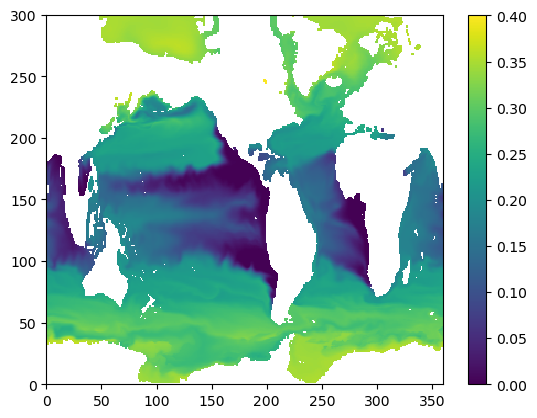

In [3]:
plt.figure()
plt.pcolormesh(dat.isel(member=0, time=0))
plt.colorbar()


## take climatology and anomaly

In [4]:
%%time

# Step 1: Calculate the climatology (mean for each month over all years)
oxy_climatology = dat.groupby("time.month").mean("time")

# Step 2: Compute the anomaly by subtracting the climatology from the original data
oxy_anomalies = dat.groupby("time.month") - oxy_climatology
oxy_anomalies


CPU times: user 10min 3s, sys: 8min, total: 18min 3s
Wall time: 8min 5s


<xarray.DataArray 'o2' (member: 40, time: 1980, j: 300, i: 360)> Size: 34GB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]], dtype=float32)
Coordinates:
  * i          (i) int32 1kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * j          (j) int32 1kB 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    latitude   (j, i) float64 864kB -77.88 -77.88 -77.88 ... 66.04 65.63 65.21
    lev        (time) float64 16kB 205.0 205.0 205.0 205.0 ... 205.0 205.0 205.0
    longitude  (j, i) float64 864kB 80.5 81.5 82.5 83.5 ... 79.96 79.97 79.99
  * time       (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-12-16T...
    month      (time) int64 16kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: member

34.2144 GB


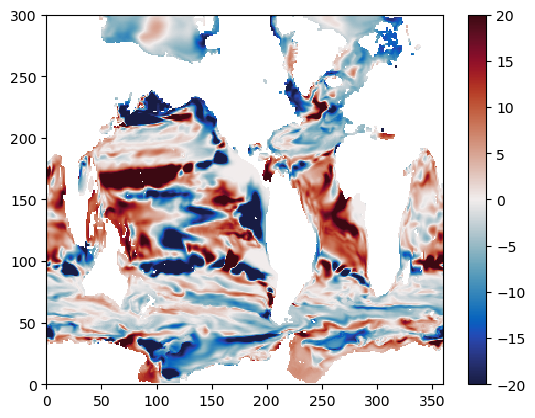

In [5]:
plt.figure()
plt.pcolormesh(oxy_anomalies.isel(member=0, time=-1)*1e3, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

print(oxy_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## detrend the data

In [ ]:
%%time

### remove global trend
def detrend_1d(arr):
    """Remove the linear trend from a 1D array."""
    x = np.arange(len(arr))
    # Fit a linear trend
    coeffs = np.polyfit(x, arr, 1)
    trend = np.polyval(coeffs, x)
    # Remove the trend
    detrended = arr - trend
    return detrended

# Apply the function to each variable in the anomalies dataset
oxy_detrended_anomalies = {}

for mem in oxy_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem+1)
    print(f"Processing: {var}")  # Print the current variable name
    
    oxy_detrended_anomalies[var] = xr.apply_ufunc(
        detrend_1d,
        oxy_anomalies.isel(member=mem),  # Apply to each variable
        input_core_dims=[["time"]],
        output_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[oxy_anomalies.isel(member=mem).dtype]
    )

# Convert dictionary back to an xarray Dataset
oxy_detrended_anomalies = xr.Dataset(oxy_detrended_anomalies)

# Check the detrended dataset
print(oxy_detrended_anomalies)


Processing: r1i1p1f1


In [ ]:
plt.figure()
plt.pcolormesh(oxy_detrended_anomalies['r1i1p1f1'].isel(time=-1)*1e3, cmap=cmo.balance, vmin=-20, vmax=20)
plt.colorbar()

print(oxy_detrended_anomalies.nbytes / 1e9, "GB")  # Convert bytes to MB

## retrieve the linear least squares trend

In [ ]:
%%time

# Create a dictionary to store trends for each variable
oxy_trends = {}

# Get the time coordinate
dates = oxy_anomalies.coords["time"]
time_length = len(dates)

for mem in oxy_anomalies.coords['member'].values:
    var = "r%ii1p1f1"%(mem+1)
    print(f"Processing: {var}")  # Print the current variable name
   
    # Compute the trend for the current variable
    var_trend = oxy_anomalies.isel(member=mem) - oxy_detrended_anomalies[var]  # Trend component
    var_trend = (var_trend.sel(time=dates[-1]) - var_trend.sel(time=dates[0])) / time_length * 12 * 10  # Scale per decade

    # Store the trend in the dictionary
    oxy_trends[var] = var_trend

# Convert the dictionary into an xarray Dataset
oxy_trends = xr.Dataset(oxy_trends)

# Print the final trends dataset
print(oxy_trends)


In [ ]:
plt.figure()
plt.pcolormesh(oxy_trends['r1i1p1f1']*1e3, cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()

plt.figure()
plt.pcolormesh(oxy_trends['r2i1p1f1']*1e3, cmap=cmo.balance, vmin=-1, vmax=1)
plt.colorbar()


## Undertake the decomposition at each grid cell across the ocean

In [14]:
%%time

from scipy.signal import hilbert

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = oxy_anomalies.coords['time'].values
lats = oxy_anomalies.coords['j'].values
lons = oxy_anomalies.coords['i'].values
# Get the latitudes and longitudes (2D arrays)
lons_2d = oxy_detrended_anomalies.coords["longitude"].values  # (j, i)
lats_2d = oxy_detrended_anomalies.coords["latitude"].values  # (j, i)

# Set up CEEMDAN
def make_ceemdan():
    ceemdan = CEEMDAN()
    ceemdan.noise_seed = 42
    ceemdan.num_siftings = 50
    ceemdan.Nstd = 0.1
    ceemdan.trials = 20
    return ceemdan


def find_imf_freq(imfs, years):
    inst_freqs = []
    for imf in imfs:
        analytic_signal = hilbert(imf)
        amplitude_envelope = np.abs(analytic_signal)
        instantaneous_phase = np.unwrap(np.angle(analytic_signal))
        instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(years))
        inst_freqs.append(instantaneous_frequency)
    return np.array([np.mean(freq) for freq in inst_freqs])
    

# Classify IMFs
def set_imfs(imfs, freqs):
    if imfs.shape[0] > 0:
        mask1 = freqs > 1
        mask2 = (freqs <= 1) & (freqs > 0.2)
        mask3 = (freqs <= 0.2) & (freqs > 0.0)
        out1 = np.mean(imfs[mask1], axis=0) if np.any(mask1) else np.zeros_like(imfs[0])
        out2 = np.mean(imfs[mask2], axis=0) if np.any(mask2) else np.zeros_like(imfs[0])
        out3 = np.mean(imfs[mask3], axis=0) if np.any(mask3) else np.zeros_like(imfs[0])
    else:
        out1 = out2 = out3 = np.zeros(len(imfs[0]))
    return np.array([out1, out2, out3])


# Main grid processing function
def process_grid_point(ix, iy, var, oxy_detrended_anomalies, years):
    ts = oxy_detrended_anomalies[var].isel(i=ix, j=iy).values
    if np.any(np.isnan(ts)):
        return (ix, iy, np.zeros((3, len(ts))))
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            ceemdan = make_ceemdan()
            imfs = ceemdan(ts, max_imf=5)
            freqs = find_imf_freq(imfs, years)
            grouped = set_imfs(imfs, freqs)
        return (ix, iy, grouped)
    except Exception as e:
        print(f"Error at ({ix},{iy}): {e}")
        return (ix, iy, np.zeros((3, len(ts))))


CPU times: user 384 μs, sys: 212 μs, total: 596 μs
Wall time: 531 μs


In [ ]:
# === Set up grid and run over variables ===
import warnings 

years = np.arange(1850+0.5/12, 2014+11.51/12, 1/12)
times = oxy_anomalies.coords['time'].values
lats = oxy_anomalies.coords['j'].values
lons = oxy_anomalies.coords['i'].values
lons_2d = oxy_detrended_anomalies.coords["longitude"].values
lats_2d = oxy_detrended_anomalies.coords["latitude"].values

nlat = len(lats)
nlon = len(lons)

save_dir = "/g/data/es60/pjb581/SPC/data/"
imf_results = {}

for mem, var in enumerate(oxy_detrended_anomalies.data_vars.keys()):
    print(f"Processing variable: {var}")
    oxy_imfs = np.zeros((3, len(times), nlat, nlon))

    coords = [(ix, iy) for iy in range(nlat) for ix in range(nlon)]
    
    results = Parallel(n_jobs=56, backend='loky', verbose=10)(
        delayed(process_grid_point)(ix, iy, var, oxy_detrended_anomalies, years) for ix, iy in coords
    )

    for ix, iy, grouped in results:
        oxy_imfs[:, :, iy, ix] = grouped

    # Save results to xarray Dataset
    name1 = f"{var}_oxy_imfs"
    name2 = f"{var}_oxy_anom"
    name3 = f"{var}_oxy_detr"
    name4 = f"{var}_oxy_trend"

    imf_da = xr.Dataset(
        {
            name1: (["IMF", "time", "j", "i"], oxy_imfs),
            name2: (["time", "j", "i"], oxy_anomalies.isel(member=mem).values),
            name3: (["time", "j", "i"], oxy_detrended_anomalies[var].transpose("time", "j", "i").values),
            name4: (["j", "i"], oxy_trends[var].values),
        },
        coords={
            "IMF": np.arange(1, 4),
            "time": times,
            "j": lats,
            "i": lons,
            "longitude": (["j", "i"], lons_2d),
            "latitude": (["j", "i"], lats_2d),
        },
    )

    file_name = f"{var}_oxy_imfs.nc"
    file_path = os.path.join(save_dir, file_name)
    imf_da.to_netcdf(file_path)
    print(f"Saved {file_name}")

    imf_results[var] = oxy_imfs

print("✅ Finished processing all variables.")


Processing variable: r1i1p1f1


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:   30.8s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   30.8s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   30.9s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   31.0s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   31.0s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   31.2s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   31.3s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   31.5s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   31.7s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   31.8s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   32.0s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   32.1s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   32.3s
[Parallel(n_jobs=56)]: Done 280 tasks      | elapsed:   32.5s
[Parallel(n_jobs=56)]: Done 309 tasks      | elapsed:  

Saved r1i1p1f1_oxy_imfs.nc
Processing variable: r2i1p1f1


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:   17.5s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   17.6s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   17.8s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   17.9s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   18.1s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   18.2s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   18.4s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   18.6s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   18.8s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   19.0s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   19.2s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   19.4s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   19.6s
[Parallel(n_jobs=56)]: Done 280 tasks      | elapsed:   19.8s
[Parallel(n_jobs=56)]: Done 309 tasks      | elapsed:  

Saved r2i1p1f1_oxy_imfs.nc
Processing variable: r3i1p1f1


[Parallel(n_jobs=56)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=56)]: Done   1 tasks      | elapsed:   20.6s
[Parallel(n_jobs=56)]: Done  16 tasks      | elapsed:   20.8s
[Parallel(n_jobs=56)]: Done  33 tasks      | elapsed:   20.9s
[Parallel(n_jobs=56)]: Done  50 tasks      | elapsed:   21.0s
[Parallel(n_jobs=56)]: Done  69 tasks      | elapsed:   21.2s
[Parallel(n_jobs=56)]: Done  88 tasks      | elapsed:   21.3s
[Parallel(n_jobs=56)]: Done 109 tasks      | elapsed:   21.5s
[Parallel(n_jobs=56)]: Done 130 tasks      | elapsed:   21.7s
[Parallel(n_jobs=56)]: Done 153 tasks      | elapsed:   21.9s
[Parallel(n_jobs=56)]: Done 176 tasks      | elapsed:   22.1s
[Parallel(n_jobs=56)]: Done 201 tasks      | elapsed:   22.3s
[Parallel(n_jobs=56)]: Done 226 tasks      | elapsed:   22.6s
[Parallel(n_jobs=56)]: Done 253 tasks      | elapsed:   22.8s
[Parallel(n_jobs=56)]: Done 280 tasks      | elapsed:   23.0s
[Parallel(n_jobs=56)]: Done 309 tasks      | elapsed:  